In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
!ln -s drive/My\ Drive/Colab\ Notebooks/Alura-Aulas_Suayder /content/Aula

In [2]:
import cv2
cv2.__version__

'3.4.2'

In [19]:
!pip uninstall opencv-python -y
# downgrade OpenCV 
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Uninstalling opencv-python-3.4.5.20:
  Successfully uninstalled opencv-python-3.4.5.20
     |████████████████████████████████| 30.6MB 1.6MB/s 
     |████████████████████████████████| 17.3MB 28.7MB/s 
ERROR: stable-baselines 2.2.1 requires opencv-python, which is not installed.
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.16.4
    Uninstalling numpy-1.16.4:
      Successfully uninstalled numpy-1.16.4
  Found existing installation: opencv-contrib-python 3.4.3.18
    Uninstalling opencv-contrib-python-3.4.3.18:
      Successfully uninstalled openc

In [8]:
import cv2
cv2.__version__

'3.4.3'

In [0]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os

In [0]:
def get_descritores_from_sift(img_caminho):
    ALTURA = 360
    LARGURA = 360

    # Ler imagens
    img_teste = cv2.imread(img_caminho) #RGB
    img_cinza = cv2.cvtColor(img_teste, cv2.COLOR_BGR2GRAY)


    # Redimensionar
    img_redimencionada = cv2.resize(img_cinza, (LARGURA, ALTURA),interpolation=cv2.INTER_CUBIC)

    # Remover o ruído (suavizar a imagem)
    img_suavizada = cv2.GaussianBlur(img_redimencionada, (5,5),1)
    img_equalizada = cv2.equalizeHist(img_suavizada)

    sift = cv2.xfeatures2d.SIFT_create(nfeatures = 512)

    # Determinar key points
    pontos_chave = sift.detect(img_equalizada, None)

    pontos_chave, descritores = sift.compute(img_equalizada, pontos_chave)
    
    return descritores

In [0]:
def salvar_descritor(descritores, caminho):

    descritores = descritores.reshape((1,descritores.size))

    arquivo=open(os.path.join(caminho, 'sift_descritores.csv'),'a')

    np.savetxt(arquivo, descritores, delimiter=',', fmt='%i')
    arquivo.close()

In [0]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

In [0]:
QUANTIDADE_PALAVRAS_VIRTUAIS = 512

class PacoteDePalavrasVirtuais:
    
    def gerar_dicionario(self, lista_descritores):

        kmeans = KMeans(n_clusters = QUANTIDADE_PALAVRAS_VIRTUAIS) # 256 Corresponde ao número de palavras virtuais que serão geradas
        kmeans = kmeans.fit(lista_descritores)
        self.dicionario = kmeans.cluster_centers_

    def histograma_de_frequencia(self, descritores):
        
        try:
            algoritmo_knn = NearestNeighbors(n_neighbors=1)
            algoritmo_knn.fit(self.dicionario)
            mais_proximos = algoritmo_knn.kneighbors(descritores, return_distance=False).flatten()
            histograma_caracteristicas = np.histogram(mais_proximos, bins=np.arange(self.dicionario.shape[0]+1))[0]
            return histograma_caracteristicas
        
        except AttributeError:
            print("O atributo dicionário não foi definido")
            
    def salvar_dicionario(self, caminho=''):
        try:
            np.savetxt(os.path.join(caminho, 'sift_dicionario.csv'), self.dicionario, delimiter=',', fmt='%f')
            print("Dicionario Salvo com sucesso.")
        except AttributeError:
            print("Dicionario esta vazio")
    
    def carregar_dicionario(self, caminho=''):
        
        self.dicionario = np.loadtxt(os.path.join(caminho, 'sift_dicionario.csv'), delimiter=',')

# MAIN

In [9]:
# Gerar dicionário

dados_treinamento = ['Aula/INRIAPerson_Dataset/treinamento/positivos/',
'Aula/INRIAPerson_Dataset/treinamento/negativos/']

# Rotina para criação do dicionário de palavras virtuais
descritores = np.empty((0,128), dtype=np.uint8)
for caminho in dados_treinamento:

    for raiz, diretorios, arquivos in os.walk(caminho):

        for arquivo in arquivos: #Somente 400 exemplos positivos e 400 exemplos negativos
            if arquivo.endswith('.png'):
                sift_descritor = get_descritores_from_sift(os.path.join(caminho, arquivo))
                descritores = np.append(descritores, sift_descritor, axis=0)

# Bag of Visual words - gerar dicionário de palavras

print("Descritores Shape: ", descritores.shape)
sift_representacao = PacoteDePalavrasVirtuais()
sift_representacao.gerar_dicionario(descritores)
sift_representacao.salvar_dicionario('Aula/')

Descritores Shape:  (404876, 128)
Dicionario Salvo com sucesso.


In [8]:
#Somente quando perder o run time do colab então carregar as variáveis necessárias

dados_treinamento = ['Aula/INRIAPerson_Dataset/treinamento/positivos/',
'Aula/INRIAPerson_Dataset/treinamento/negativos/']

sift_representacao = PacoteDePalavrasVirtuais()
sift_representacao.carregar_dicionario('Aula')
print(sift_representacao.dicionario.shape)

(512, 128)


In [10]:
# computar descritores gerando histograma de cada imagem separadamente

for caminho in dados_treinamento:
    
    arquivo_descritores = os.path.join(caminho,'sift_descritores.csv')
    if os.path.exists(arquivo_descritores):
        os.remove(arquivo_descritores)

    for raiz, diretorios, arquivos in os.walk(caminho):
        for arquivo in arquivos: #Somente 400 exemplos positivos e 400 exemplos negativos
            if arquivo.endswith('.png'):
                descritor = get_descritores_from_sift(os.path.join(caminho, arquivo))
                hitograma_descritor = sift_representacao.histograma_de_frequencia(descritor)
                salvar_descritor(hitograma_descritor, caminho)
print("Data set salvo")

Data set salvo


# Rotina de classificação

In [0]:
def carregar_descritores(caminho):

    descritores = np.loadtxt(os.path.join(caminho, 'sift_descritores.csv'), delimiter=',')
    print("formato do array de descritores: ",descritores.shape) #Para justificar o '400' do bloco de classificação
    return descritores

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [14]:
#Carregar os descritores salvos

descritores = np.empty((0,QUANTIDADE_PALAVRAS_VIRTUAIS))
for caminho in dados_treinamento:
    descritores = np.append(descritores, carregar_descritores(caminho), axis=0)

formato do array de descritores:  (400, 512)
formato do array de descritores:  (400, 512)


In [22]:
#KNN para classificar as imagens

#Contar aruivos na pasta

QUANTIDADE_DE_DADOS_TREINAMENTO = 400
QUANTIDADE_DE_DADOS_TESTE = 100

rotulos = np.ones(QUANTIDADE_DE_DADOS_TREINAMENTO, dtype=np.uint8) #Rotular as primeiras 400 caracteristicas como 1 - Exemplos sem imagem
rotulos = np.append(rotulos, np.zeros(QUANTIDADE_DE_DADOS_TREINAMENTO, dtype=np.uint8)) #Rotular as outras 400 como zero - Exemplos sem imagem

knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(descritores, rotulos)

# Ler imagens. 100 positivas e 100 negativas

dados_teste = ['Aula/INRIAPerson_Dataset/teste/positivos/',
'Aula/INRIAPerson_Dataset/teste/negativos/']
sift_test_descritores = np.empty((0,QUANTIDADE_PALAVRAS_VIRTUAIS), dtype=np.uint8)

for caminho in dados_teste:

    for raiz, diretorios, arquivos in os.walk(caminho):
        for arquivo in arquivos:

            if arquivo.endswith('.png'):

                sift_descritor = get_descritores_from_sift(os.path.join(caminho, arquivo))
                sift_descritor = sift_representacao.histograma_de_frequencia(sift_descritor)
                img_dim_expandida = np.expand_dims(sift_descritor, axis=0)
                sift_test_descritores = np.append(sift_test_descritores, img_dim_expandida, axis=0)

rotulos_teste = np.concatenate((np.ones(QUANTIDADE_DE_DADOS_TESTE, dtype=np.uint8), np.zeros(QUANTIDADE_DE_DADOS_TESTE, dtype=np.uint8))) 
print("Acurácia: ", knn.score(sift_test_descritores, rotulos_teste))

Acurácia:  0.62


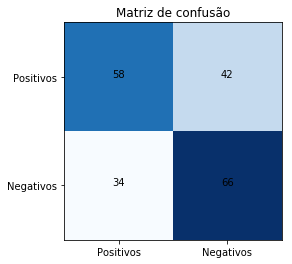

In [38]:
# Plotar matriz de confusão

from sklearn.metrics import confusion_matrix

rotulos_previstos = knn.predict(sift_test_descritores)
matriz = confusion_matrix(rotulos_teste, rotulos_previstos)


plt.imshow(matriz,cmap=plt.cm.Blues,interpolation='nearest')
plt.title("Matriz de confusão")

labels = ['Positivos', 'Negativos']

marcador_escalas = range(len(labels))

plt.yticks(marcador_escalas,labels)
plt.xticks(marcador_escalas,labels)


for linha in range(matriz.shape[0]):
    for coluna in range(matriz.shape[1]):
        plt.text(coluna,linha,format(matriz[linha,coluna]),horizontalalignment='center',color='black')
plt.show();

### A rede neural já gera um melhor resultado, mas a ideia é deixar ela para um próximo curso que será somente de classificação de imagens com redes neurais

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

np.random.seed(7)

model = Sequential()
model.add(Dense(512, input_dim=512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(descritores, to_categorical(rotulos), epochs=40, batch_size=15)

Epoch 1/40
800/800 [==============================] - 1s 2ms/step - loss: 0.9905 - acc: 0.6038
Epoch 2/40
800/800 [==============================] - 0s 493us/step - loss: 0.4881 - acc: 0.7638
Epoch 3/40
800/800 [==============================] - 0s 507us/step - loss: 0.4187 - acc: 0.8188
Epoch 4/40
800/800 [==============================] - 0s 479us/step - loss: 0.2965 - acc: 0.8788
Epoch 5/40
800/800 [==============================] - 0s 497us/step - loss: 0.2219 - acc: 0.9213
Epoch 6/40
800/800 [==============================] - 0s 476us/step - loss: 0.1427 - acc: 0.9413
Epoch 7/40
800/800 [==============================] - 0s 504us/step - loss: 0.0880 - acc: 0.9663
Epoch 8/40
800/800 [==============================] - 0s 474us/step - loss: 0.0583 - acc: 0.9838
Epoch 9/40
800/800 [==============================] - 0s 497us/step - loss: 0.0807 - acc: 0.9675
Epoch 10/40
800/800 [==============================] - 0s 502us/step - loss: 0.0542 - acc: 0.9800
Epoch 11/40
800/800 [==========

In [36]:
scores = model.evaluate(sift_test_descritores, to_categorical(rotulos_teste))
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

200/200 [==============================] - 0s 2ms/step

acc: 73.00%
